In [10]:
# Importing Libraries

import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
from joblib import dump
from wordcloud import WordCloud


In [11]:
# Load the dataset
df = pd.read_csv('Dataset\Tweets.csv')

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


- Exploratory Data Analysis

In [12]:
print(df['airline_sentiment'].value_counts())
print(df.info())
print(df.describe(include='all'))


airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord             

- Data Cleaning and Handling Missing Values

In [13]:
df['text'].fillna("", inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_12928\2625947320.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['text'].fillna("", inplace=True)


In [14]:
df['negativereason'].fillna("None", inplace=True)

df['tweet_location'].fillna("Unknown", inplace=True)

df.dropna(subset=['airline_sentiment_confidence', 'text'], inplace=True)




C:\Users\hp\AppData\Local\Temp\ipykernel_12928\4134183376.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['negativereason'].fillna("None", inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_12928\4134183376.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

- Text Preprocessing Function

In [15]:
# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")

SyntaxError: incomplete input (2443126431.py, line 3)

In [16]:
try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model loaded successfully.")
except Exception as e:
    print("Error loading spaCy model:", str(e))

spaCy model loaded successfully.


In [17]:
def spacy_preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.like_url and not token.like_email and not token.text.startswith('@') and not token.is_space]
    return " ".join(tokens)

# Preprocess the text column
df['spacy_processed_text'] = df['text'].apply(spacy_preprocess)

- Sentiment Encoding

In [18]:
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_score'] = df['airline_sentiment'].map(sentiment_map)

- Topic-Specific Sentiment Analysis

In [19]:
topics = ['flight', 'service', 'delay', 'staff', 'price']
for topic in topics:
    df[f'sentiment_{topic}'] = df['spacy_processed_text'].apply(lambda x: 1 if topic in x else 0)

- Feature Extraction using TF-IDF

In [20]:
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['spacy_processed_text'])
y = df['sentiment_score']

- Train/Test Split and Model Training

In [21]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training Logistic Regression model
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Save the model
dump(model, 'models/sentiment_model.joblib')


Accuracy: 0.7855191256830601

Classification Report:
               precision    recall  f1-score   support

          -1       0.82      0.93      0.87      1889
           0       0.62      0.47      0.54       580
           1       0.79      0.60      0.68       459

    accuracy                           0.79      2928
   macro avg       0.74      0.67      0.70      2928
weighted avg       0.78      0.79      0.77      2928



['models/sentiment_model.joblib']

- Sentiment Distribution

C:\Users\hp\AppData\Local\Temp\ipykernel_12928\3256613723.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline_sentiment', data=df, palette='Set2')


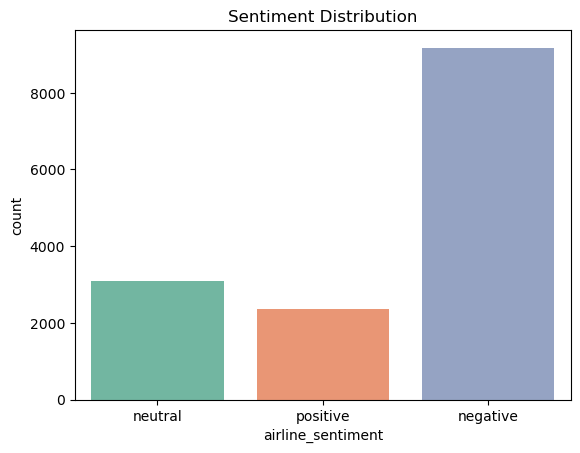

<Figure size 640x480 with 0 Axes>

In [22]:
sns.countplot(x='airline_sentiment', data=df, palette='Set2')
plt.title('Sentiment Distribution')
plt.show()
plt.savefig('images\Sentiment_Distribution.png', dpi=300, bbox_inches='tight')

- Confusion Matrix

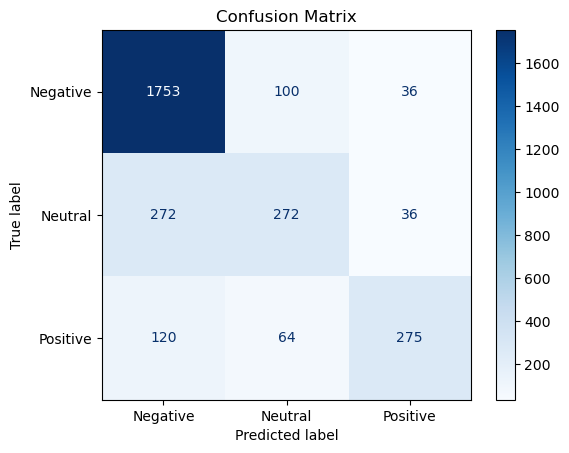

In [23]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('images/Confusion_Matrix.png', dpi=300, bbox_inches='tight')

- ROC Curve

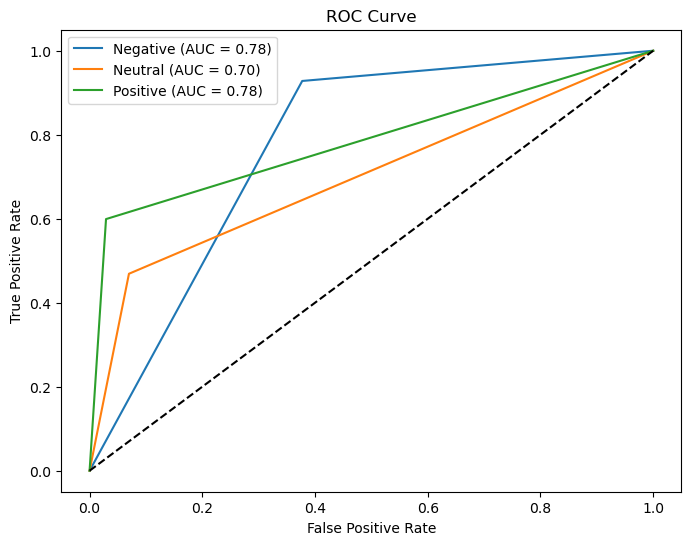

In [24]:
y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])
y_pred_bin = label_binarize(y_pred, classes=[-1, 0, 1])
plt.figure(figsize=(8, 6))
for i, label in enumerate(['Negative', 'Neutral', 'Positive']):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('images/ROC_Curve.png', dpi=300, bbox_inches='tight')

- Word Clouds for Sentiment Classes

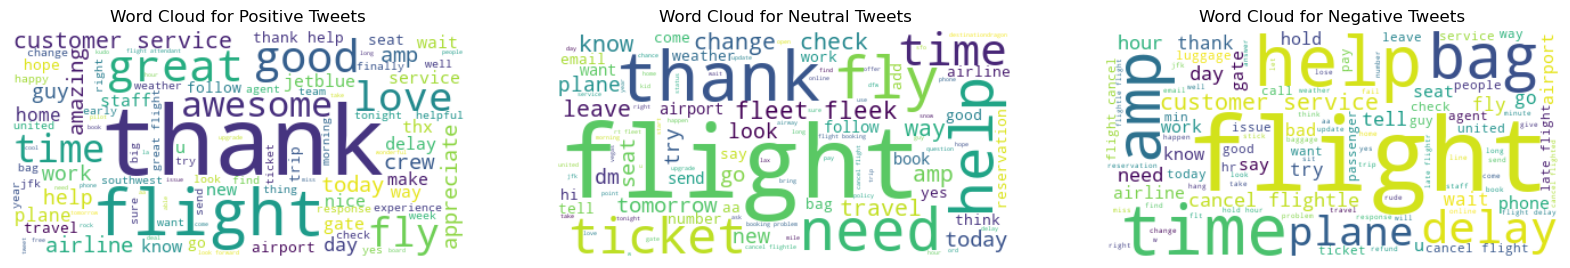

<Figure size 640x480 with 0 Axes>

In [25]:
from wordcloud import WordCloud

# Word clouds for positive, neutral, and negative tweets
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for ax, sentiment in zip(axes, ['positive', 'neutral', 'negative']):
    text = " ".join(df[df['airline_sentiment'] == sentiment]['spacy_processed_text'])
    wordcloud = WordCloud(background_color='white', max_words=100).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud for {sentiment.capitalize()} Tweets')
    ax.axis('off')

plt.show()
plt.savefig('images\Tweets_Word_Cloud.png', dpi=300, bbox_inches='tight')

- Topic-Specific Sentiment Visualization

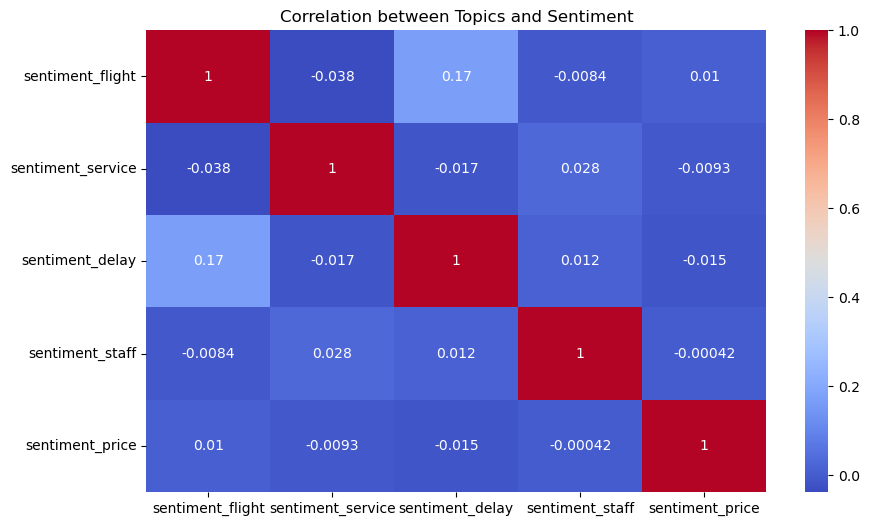

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df[[f'sentiment_{topic}' for topic in topics]].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between Topics and Sentiment')
plt.savefig('images/Topic_Sentiment_Correlation.png', dpi=300, bbox_inches='tight')

In [27]:
# Export the processed data to CSV
df.to_csv('Dataset\processed_twitter_sentiment.csv', index=False)
print("Data exported successfully to 'processed_twitter_sentiment.csv'.")


Data exported successfully to 'processed_twitter_sentiment.csv'.
